# import data

In [122]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import resample
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import friedmanchisquare, rankdata
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc



# Read data

In [3]:
# read data
data = pd.read_csv("alzheimers_disease_data.csv")
data.shape
data.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)

In [5]:
data.shape

(2149, 33)

# Balancing 

- why balabcing
- strugle in balancing and selecting under sampling 

In [7]:
class_counts = data.iloc[:, -1].value_counts(normalize=True) * 100
print("Original Class Distribution:\n", class_counts)

# Splitting features and target variable
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Separate majority and minority classes
majority_class = data[y == 0]  # Non-Alzheimer's (64.6%)
minority_class = data[y == 1]  # Alzheimer's (35.4%)

# Undersample the majority class to match the minority class size
majority_downsampled = resample(majority_class, 
                                replace=False,  # Without replacement
                                n_samples=len(minority_class),  # Match minority class size
                                random_state=42)

# Combine the downsampled majority class with the original minority class
balanced_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
new_class_counts = balanced_data.iloc[:, -1].value_counts(normalize=True) * 100
print("Balanced Class Distribution:\n", new_class_counts)

Original Class Distribution:
 Diagnosis
0    64.634714
1    35.365286
Name: proportion, dtype: float64
Balanced Class Distribution:
 Diagnosis
0    50.0
1    50.0
Name: proportion, dtype: float64


In [9]:
balanced_data.shape

(1520, 33)

# Encoding 

In [11]:
# Step 1: Select the nominal categorical features
nominal_features = ['Ethnicity', 'EducationLevel']

# Step 2: Initialize One-Hot Encoder without dropping any category
ohe = OneHotEncoder(drop=None, sparse_output=False)  # Keep all categories

# Step 3: Fit and transform the categorical features
encoded_features = ohe.fit_transform(balanced_data[nominal_features])

# Step 4: Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(nominal_features))

# Step 5: Drop the original categorical columns and merge encoded features
data = balanced_data.drop(columns=nominal_features).reset_index(drop=True)  # Drop original categorical columns
data = pd.concat([data, encoded_df], axis=1)  # Merge encoded data

# Step 6: Verify the transformed data
print("Updated Dataset After One-Hot Encoding:")
data.head()

Updated Dataset After One-Hot Encoding:


,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,Forgetfulness,Diagnosis,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,EducationLevel_0,EducationLevel_1,EducationLevel_2,EducationLevel_3
0,80,1,16.834968,0,19.053565,4.352272,3.432055,7.361459,0,0,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,88,1,35.353244,1,0.768943,8.883326,4.085773,7.450835,0,0,...,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,63,0,32.726550,0,16.971929,8.569751,8.744619,9.227229,0,0,...,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,75,1,38.668960,1,6.669039,7.328895,7.973275,9.966551,0,0,...,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,72,0,30.646711,0,4.452856,0.768016,4.978013,7.715735,0,1,...,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
data.shape

(1520, 39)

In [99]:
# selected_features = [
#     'FunctionalAssessment', 'ADL', 'MemoryComplaints', 'MMSE', 'BehavioralProblems', 'SleepQuality'
# ]

In [15]:
selected_features = ['FunctionalAssessment', 'ADL', 'MemoryComplaints', 'MMSE', 'BehavioralProblems', 'SleepQuality', 'CholesterolHDL', 'CholesterolLDL', 'BMI', 'CholesterolTriglycerides', 'Age', 'PhysicalActivity', 'DietQuality', 'DiastolicBP', 'Gender']

In [21]:
print(len(selected_features))

15


In [17]:
X = data[selected_features]  
y = data['Diagnosis']

In [25]:
data.shape

(1520, 39)

# split after feature selection and scale

In [19]:
# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
scaler = StandardScaler()

# Fit on training data and transform both train and test separately
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

In [112]:
combined_data = X.copy()
combined_data['Diagnosis'] = y

# Save to CSV file
combined_csv_path = "combined_data.csv"
combined_data.to_csv(combined_csv_path, index=False)

# Provide download link
combined_csv_path

In [33]:
newdata = pd.read_csv("combined_data.csv")

# Check for missing or NaN values
missing_values = newdata.isnull().sum()

# Display missing values
missing_values

FunctionalAssessment        0
ADL                         0
MemoryComplaints            0
MMSE                        0
BehavioralProblems          0
SleepQuality                0
CholesterolHDL              0
CholesterolLDL              0
BMI                         0
CholesterolTriglycerides    0
Age                         0
PhysicalActivity            0
DietQuality                 0
DiastolicBP                 0
Gender                      0
Diagnosis                   0
dtype: int64

# Fit and Predict

## DT

In [41]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train_scaled, y_train)

dt_y_pred = dt.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, dt_y_pred))

print("Classification Report:\n", classification_report(y_test, dt_y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_y_pred))

Accuracy: 0.881578947368421
Classification Report:
               precision    recall  f1-score   support

           0      0.881     0.881     0.881       151
           1      0.882     0.882     0.882       153

    accuracy                          0.882       304
   macro avg      0.882     0.882     0.882       304
weighted avg      0.882     0.882     0.882       304

Confusion Matrix:
 [[133  18]
 [ 18 135]]


## RF

In [43]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)  # 100 trees in the forest

rf.fit(X_train_scaled, y_train)

rf_y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, rf_y_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))


Accuracy: 0.9342105263157895

Classification Report:
               precision    recall  f1-score   support

           0      0.912     0.960     0.935       151
           1      0.959     0.908     0.933       153

    accuracy                          0.934       304
   macro avg      0.935     0.934     0.934       304
weighted avg      0.935     0.934     0.934       304


Confusion Matrix:
 [[145   6]
 [ 14 139]]


## XGBoost

In [47]:
xgb = XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')

xgb.fit(X_train_scaled, y_train)

xgb_y_pred = xgb.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, xgb_y_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, xgb_y_pred))

Accuracy: 0.9243421052631579

Classification Report:
               precision    recall  f1-score   support

           0      0.916     0.934     0.925       151
           1      0.933     0.915     0.924       153

    accuracy                          0.924       304
   macro avg      0.924     0.924     0.924       304
weighted avg      0.925     0.924     0.924       304


Confusion Matrix:
 [[141  10]
 [ 13 140]]


## Catboost

In [27]:
!pip install catboost

In [49]:
catboost = CatBoostClassifier(random_state=42, iterations=100, verbose=0)  # 100 iterations, silent training

catboost.fit(X_train_scaled, y_train)

catboost_y_pred = catboost.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, catboost_y_pred))
print("\nClassification Report:\n", classification_report(y_test, catboost_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, catboost_y_pred))


Accuracy: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0      0.923     0.954     0.938       151
           1      0.953     0.922     0.937       153

    accuracy                          0.938       304
   macro avg      0.938     0.938     0.937       304
weighted avg      0.938     0.938     0.937       304


Confusion Matrix:
 [[144   7]
 [ 12 141]]


## AdaBoost

In [51]:
adaboost = AdaBoostClassifier(random_state=42, n_estimators=100)  # 100 weak learners

adaboost.fit(X_train_scaled, y_train)

adaboost_y_pred = adaboost.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, adaboost_y_pred))
print("\nClassification Report:\n", classification_report(y_test, adaboost_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, adaboost_y_pred))


C:\Users\chapp\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8848684210526315

Classification Report:
               precision    recall  f1-score   support

           0      0.939     0.821     0.876       151
           1      0.843     0.948     0.892       153

    accuracy                          0.885       304
   macro avg      0.891     0.884     0.884       304
weighted avg      0.891     0.885     0.884       304


Confusion Matrix:
 [[124  27]
 [  8 145]]


## SVM

In [53]:
# Initialize SVM Classifier
svm = SVC(random_state=42, kernel='rbf')  # Using RBF kernel (default)

# Train the model
svm.fit(X_train_scaled, y_train)

# Make predictions
svm_y_pred = svm.predict(X_test_scaled)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, svm_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_y_pred))


Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0      0.865     0.887     0.876       151
           1      0.886     0.863     0.874       153

    accuracy                          0.875       304
   macro avg      0.875     0.875     0.875       304
weighted avg      0.875     0.875     0.875       304


Confusion Matrix:
 [[134  17]
 [ 21 132]]


# Stratified cross validation

### RF

In [61]:

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)  # 100 trees in the forest

# Apply 10-Fold Stratified Cross-Validation
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform 10-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(stratified_cv.split(X_train_scaled, y_train), 1):
    X_train_fold, X_test_fold = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Train model on current fold
    rf.fit(X_train_fold, y_train_fold)
    y_pred_fold = rf.predict(X_test_fold)

    # Calculate metrics
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted')  # Weighted for class imbalance
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')

    # Store results
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Print metrics for current fold
    print(f"Fold {fold}:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}\n")

# Print average results across all folds
print("\nFinal Cross-Validation Results for RF (Average Over 10 Folds):")
print(f"  Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}")
print(f"  Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"  Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"  F1-Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")


Fold 1:
  Accuracy: 0.951
  Precision: 0.955
  Recall: 0.951
  F1-Score: 0.951

Fold 2:
  Accuracy: 0.926
  Precision: 0.926
  Recall: 0.926
  F1-Score: 0.926

Fold 3:
  Accuracy: 0.934
  Precision: 0.934
  Recall: 0.934
  F1-Score: 0.934

Fold 4:
  Accuracy: 0.967
  Precision: 0.969
  Recall: 0.967
  F1-Score: 0.967

Fold 5:
  Accuracy: 0.959
  Precision: 0.960
  Recall: 0.959
  F1-Score: 0.959

Fold 6:
  Accuracy: 0.918
  Precision: 0.918
  Recall: 0.918
  F1-Score: 0.918

Fold 7:
  Accuracy: 0.926
  Precision: 0.931
  Recall: 0.926
  F1-Score: 0.925

Fold 8:
  Accuracy: 0.950
  Precision: 0.951
  Recall: 0.950
  F1-Score: 0.950

Fold 9:
  Accuracy: 0.926
  Precision: 0.931
  Recall: 0.926
  F1-Score: 0.925

Fold 10:
  Accuracy: 0.942
  Precision: 0.942
  Recall: 0.942
  F1-Score: 0.942


Final Cross-Validation Results for RF (Average Over 10 Folds):
  Accuracy: 0.940 ± 0.016
  Precision: 0.942 ± 0.016
  Recall: 0.940 ± 0.016
  F1-Score: 0.940 ± 0.016


### Catboost

In [63]:


# Initialize CatBoost Classifier
catboost = CatBoostClassifier(random_state=42, iterations=100, verbose=0)  # 100 iterations, silent training

# Apply 10-Fold Stratified Cross-Validation
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform 10-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(stratified_cv.split(X_train_scaled, y_train), 1):
    X_train_fold, X_test_fold = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Train model on current fold
    catboost.fit(X_train_fold, y_train_fold)
    y_pred_fold = catboost.predict(X_test_fold)

    # Calculate metrics
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted')  # Weighted for class imbalance
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')

    # Store results
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Print metrics for current fold
    print(f"Fold {fold}:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}\n")

# Print average results across all folds
print("\nFinal Cross-Validation Results for catboost (Average Over 10 Folds):")
print(f"  Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}")
print(f"  Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"  Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"  F1-Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")


Fold 1:
  Accuracy: 0.951
  Precision: 0.955
  Recall: 0.951
  F1-Score: 0.951

Fold 2:
  Accuracy: 0.926
  Precision: 0.926
  Recall: 0.926
  F1-Score: 0.926

Fold 3:
  Accuracy: 0.943
  Precision: 0.943
  Recall: 0.943
  F1-Score: 0.943

Fold 4:
  Accuracy: 0.975
  Precision: 0.977
  Recall: 0.975
  F1-Score: 0.975

Fold 5:
  Accuracy: 0.967
  Precision: 0.968
  Recall: 0.967
  F1-Score: 0.967

Fold 6:
  Accuracy: 0.951
  Precision: 0.951
  Recall: 0.951
  F1-Score: 0.951

Fold 7:
  Accuracy: 0.926
  Precision: 0.928
  Recall: 0.926
  F1-Score: 0.925

Fold 8:
  Accuracy: 0.950
  Precision: 0.951
  Recall: 0.950
  F1-Score: 0.950

Fold 9:
  Accuracy: 0.917
  Precision: 0.921
  Recall: 0.917
  F1-Score: 0.917

Fold 10:
  Accuracy: 0.959
  Precision: 0.960
  Recall: 0.959
  F1-Score: 0.959


Final Cross-Validation Results for catboost (Average Over 10 Folds):
  Accuracy: 0.947 ± 0.018
  Precision: 0.948 ± 0.017
  Recall: 0.947 ± 0.018
  F1-Score: 0.946 ± 0.018


### XGboost

In [65]:


# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')

# Apply 10-Fold Stratified Cross-Validation
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform 10-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(stratified_cv.split(X_train_scaled, y_train), 1):
    X_train_fold, X_test_fold = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Train model on current fold
    xgb.fit(X_train_fold, y_train_fold)
    y_pred_fold = xgb.predict(X_test_fold)

    # Calculate metrics
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted')  # Weighted for class imbalance
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')

    # Store results
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Print metrics for current fold
    print(f"Fold {fold}:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}\n")

# Print average results across all folds
print("\nFinal Cross-Validation Results for XGboost (Average Over 10 Folds):")
print(f"  Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}")
print(f"  Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"  Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"  F1-Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")


Fold 1:
  Accuracy: 0.943
  Precision: 0.946
  Recall: 0.943
  F1-Score: 0.943

Fold 2:
  Accuracy: 0.943
  Precision: 0.943
  Recall: 0.943
  F1-Score: 0.943

Fold 3:
  Accuracy: 0.943
  Precision: 0.943
  Recall: 0.943
  F1-Score: 0.943

Fold 4:
  Accuracy: 0.975
  Precision: 0.977
  Recall: 0.975
  F1-Score: 0.975

Fold 5:
  Accuracy: 0.959
  Precision: 0.960
  Recall: 0.959
  F1-Score: 0.959

Fold 6:
  Accuracy: 0.926
  Precision: 0.929
  Recall: 0.926
  F1-Score: 0.926

Fold 7:
  Accuracy: 0.917
  Precision: 0.921
  Recall: 0.917
  F1-Score: 0.917

Fold 8:
  Accuracy: 0.950
  Precision: 0.951
  Recall: 0.950
  F1-Score: 0.950

Fold 9:
  Accuracy: 0.909
  Precision: 0.918
  Recall: 0.909
  F1-Score: 0.909

Fold 10:
  Accuracy: 0.926
  Precision: 0.926
  Recall: 0.926
  F1-Score: 0.926


Final Cross-Validation Results for XGboost (Average Over 10 Folds):
  Accuracy: 0.939 ± 0.019
  Precision: 0.941 ± 0.017
  Recall: 0.939 ± 0.019
  F1-Score: 0.939 ± 0.019


# parameter tuning

### RF

In [55]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-Fold Cross-Validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit on training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train Random Forest with best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Make predictions
rf_y_pred = best_rf.predict(X_test_scaled)

# Print evaluation metrics
print("\nAccuracy:", accuracy_score(y_test, rf_y_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Accuracy: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0      0.923     0.954     0.938       151
           1      0.953     0.922     0.937       153

    accuracy                          0.938       304
   macro avg      0.938     0.938     0.937       304
weighted avg      0.938     0.938     0.937       304


Confusion Matrix:
 [[144   7]
 [ 12 141]]


### cat

In [57]:
# Define the hyperparameter grid
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'loss_function': ['Logloss']
}

# Initialize the CatBoost model
catboost = CatBoostClassifier(random_state=42, verbose=0)

# Perform Grid Search with 5-Fold Cross-Validation
grid_search = GridSearchCV(catboost, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit on training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train CatBoost with best parameters
best_catboost = CatBoostClassifier(**best_params, random_state=42, verbose=0)
best_catboost.fit(X_train_scaled, y_train)

# Make predictions
catboost_y_pred = best_catboost.predict(X_test_scaled)

# Print evaluation metrics
print("\nAccuracy:", accuracy_score(y_test, catboost_y_pred))
print("\nClassification Report:\n", classification_report(y_test, catboost_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, catboost_y_pred))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'border_count': 128, 'depth': 4, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.01, 'loss_function': 'Logloss'}

Accuracy: 0.9407894736842105

Classification Report:
               precision    recall  f1-score   support

           0      0.929     0.954     0.941       151
           1      0.953     0.928     0.940       153

    accuracy                          0.941       304
   macro avg      0.941     0.941     0.941       304
weighted avg      0.941     0.941     0.941       304


Confusion Matrix:
 [[144   7]
 [ 11 142]]


## Stacking

In [83]:
# Create the individual classifiers
rf = make_pipeline(StandardScaler(),  RandomForestClassifier(
    bootstrap=False, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200, 
    random_state=42  ))
catboost = make_pipeline(StandardScaler(), CatBoostClassifier(
    border_count=128, 
    depth=4, 
    iterations=500, 
    l2_leaf_reg=3, 
    learning_rate=0.01, 
    loss_function='Logloss', 
    random_seed=42,  
    verbose=0  ))

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('catboost', catboost)],  # Base models
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)  # Meta learner
)


# Perform cross-validation predictions
stacking_preds = cross_val_predict(stacking_clf, X_train, y_train, cv=5)

# Train the classifiers on the full training set
stacking_clf.fit(X_train, y_train)

# Predict on the test set
stacking_test_preds = stacking_clf.predict(X_test)

# Function to print classification report
def print_classification_report(y_true, y_pred, title):
    print(f"\n{title}")
    print(classification_report(y_true, y_pred))

# Print classification reports
print(classification_report(y_test, stacking_test_preds, digits = 3))
print(confusion_matrix(y_test, stacking_test_preds))


              precision    recall  f1-score   support

           0      0.906     0.947     0.926       152
           1      0.945     0.901     0.923       152

    accuracy                          0.924       304
   macro avg      0.925     0.924     0.924       304
weighted avg      0.925     0.924     0.924       304

[[144   8]
 [ 15 137]]


## Friedman test

In [77]:
# Define models
models = {
    'Stacking': stacking_clf,  
    'Random Forest': RandomForestClassifier(
    bootstrap=False, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200, 
    random_state=42  ),
    'CatBoost': CatBoostClassifier(
    border_count=128, 
    depth=4, 
    iterations=500, 
    l2_leaf_reg=3, 
    learning_rate=0.01, 
    loss_function='Logloss', 
    random_seed=42,  
    verbose=0  )
}

# Initialize K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store scores
model_scores = {model_name: [] for model_name in models.keys()}

# Perform K-Fold Cross-Validation
for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred)  # You can use other metrics like F1-score
        model_scores[model_name].append(score)

# Print scores
for model_name, scores in model_scores.items():
    print(f"{model_name} Scores: {scores}")


# Convert model scores to a matrix
scores_matrix = np.array([model_scores[model_name] for model_name in models.keys()])

# Perform Friedman Test
stat, p = friedmanchisquare(*scores_matrix)
print("Friedman Test Statistic:", stat)
print("P-value:", p)

# Rank models for each fold
ranks = np.array([rankdata(-fold_scores) for fold_scores in scores_matrix.T])
avg_ranks = ranks.mean(axis=0)

# Print model rankings
model_names = list(models.keys())
for model, rank in zip(model_names, avg_ranks):
    print(f"{model}: Average Rank = {rank:.2f}")

# Sort and display rankings
sorted_models = sorted(zip(model_names, avg_ranks), key=lambda x: x[1])
print("\nModel Rankings:")
for i, (model, rank) in enumerate(sorted_models, 1):
    print(f"{i}. {model} (Average Rank: {rank:.2f})")
    print("\n")
    

Stacking Scores: [0.9463087248322147, 0.9292929292929293, 0.9530201342281879, 0.9355932203389831, 0.9225589225589226]
Random Forest Scores: [0.9463087248322147, 0.936026936026936, 0.9387755102040817, 0.9364548494983278, 0.9266666666666666]
CatBoost Scores: [0.9463087248322147, 0.9431438127090301, 0.96, 0.9463087248322147, 0.9230769230769231]
Friedman Test Statistic: 4.500000000000002
P-value: 0.10539922456186428
Stacking: Average Rank = 2.60
Random Forest: Average Rank = 2.00
CatBoost: Average Rank = 1.40

Model Rankings:
1. CatBoost (Average Rank: 1.40)


2. Random Forest (Average Rank: 2.00)


3. Stacking (Average Rank: 2.60)




## ROC Curve & AUC Score (Receiver Operating Characteristic)

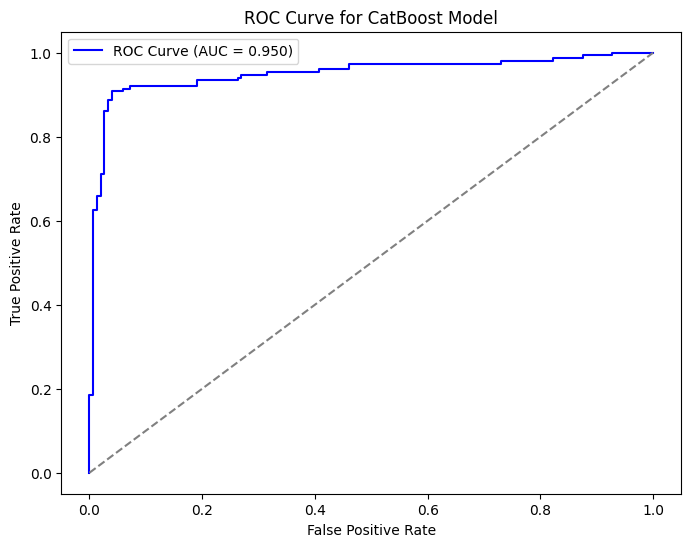

In [108]:
catboost = CatBoostClassifier(
    border_count=128, 
    depth=4, 
    iterations=500, 
    l2_leaf_reg=3, 
    learning_rate=0.01, 
    loss_function='Logloss', 
    random_seed=42,  
    verbose=0  
)

# Train the model
catboost.fit(X_train, y_train)

# Get model predictions (probabilities)
y_probs = catboost.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model')
plt.legend()
plt.show()

## Explainability 

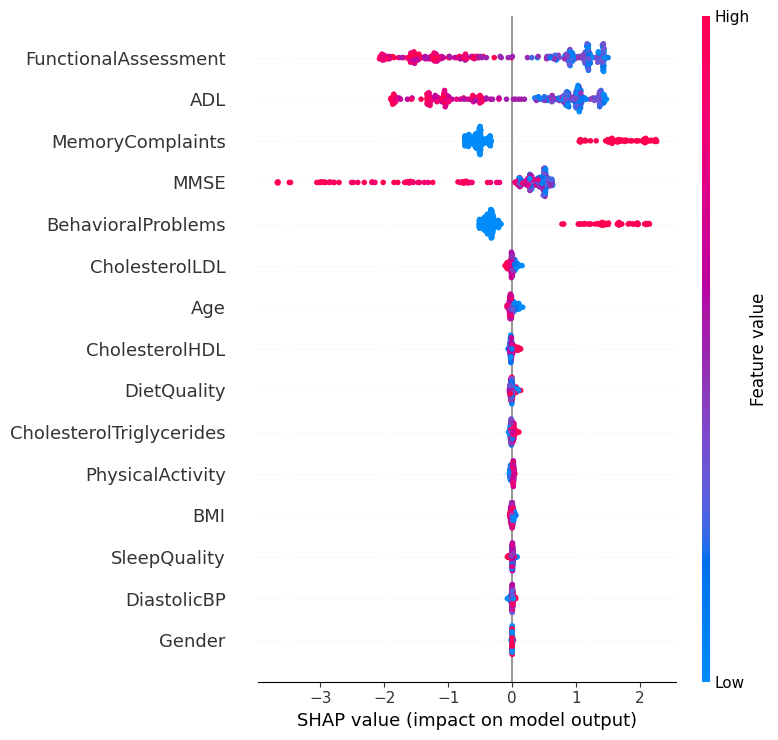

In [126]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)
